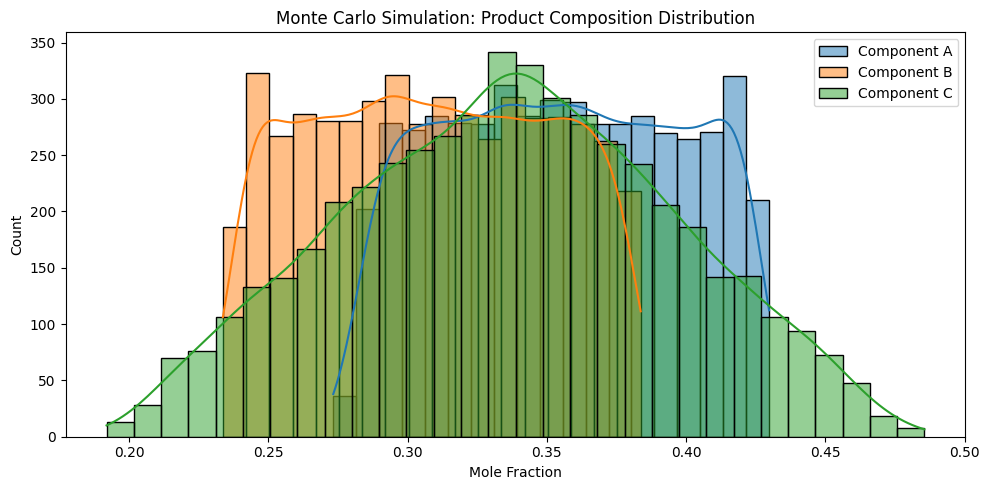

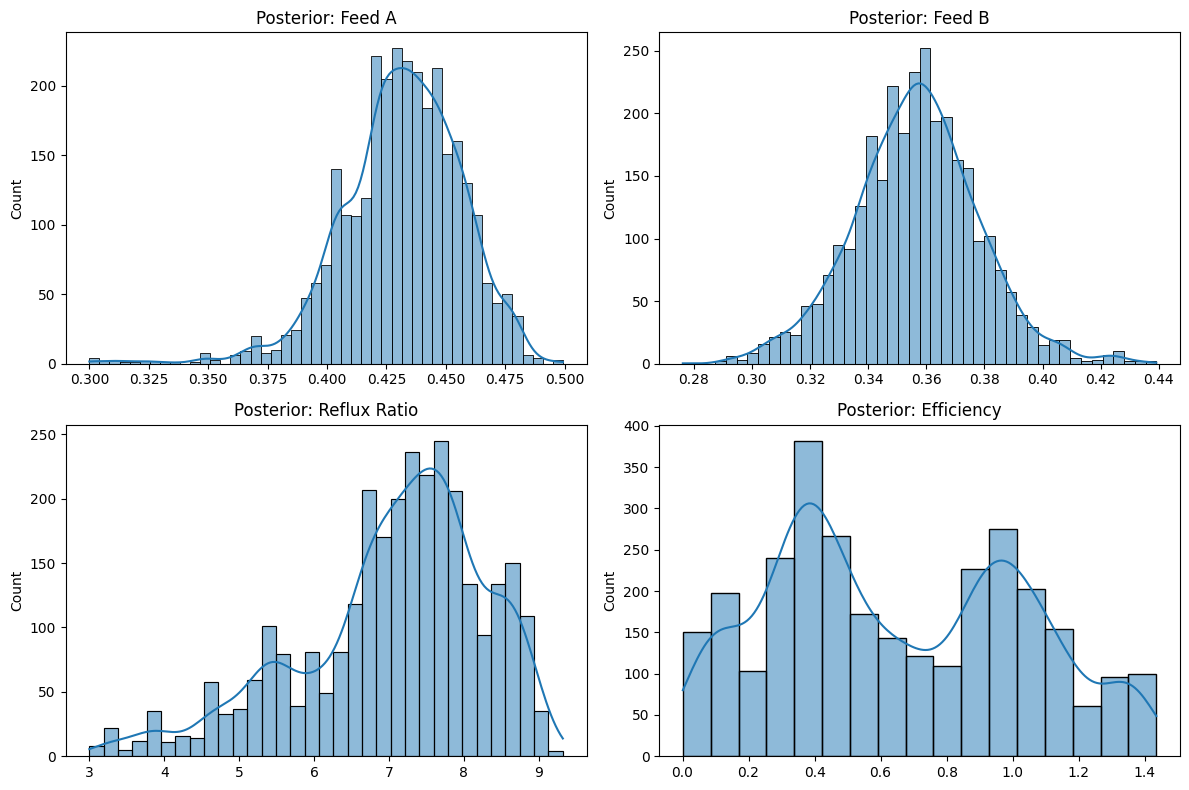

In [1]:
# Stochastic Modeling of Ternary Distillation via Monte Carlo + MCMC (Metropolis-Hastings)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Simulate Distillation Model
# -----------------------------
def simulate_ternary_distillation(feed_A, feed_B, reflux_ratio, stage_efficiency):
    total_feed = feed_A + feed_B
    if total_feed >= 1.0 or feed_A <= 0 or feed_B <= 0 or reflux_ratio <= 0 or stage_efficiency <= 0:
        return 0  # invalid values
    feed_C = 1.0 - total_feed

    # Separation logic: better reflux/efficiency = better separation
    sep_factor = (reflux_ratio / (reflux_ratio + 1)) * stage_efficiency
    xD_A = feed_A + 0.3 * sep_factor
    xD_B = feed_B + 0.2 * sep_factor
    xD_C = feed_C + 0.1 * sep_factor

    total = xD_A + xD_B + xD_C
    return [xD_A / total, xD_B / total, xD_C / total]

# -----------------------------
# 2. Monte Carlo Simulation
# -----------------------------
np.random.seed(42)
samples = 5000
results = []

for _ in range(samples):
    feed_A = np.random.uniform(0.2, 0.4)
    feed_B = np.random.uniform(0.2, 0.4)
    reflux = np.random.normal(3, 0.5)
    eff = np.random.normal(0.85, 0.05)
    result = simulate_ternary_distillation(feed_A, feed_B, reflux, eff)
    if result:
        results.append(result)

results = np.array(results)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(results[:, 0], kde=True, label='Component A')
sns.histplot(results[:, 1], kde=True, label='Component B')
sns.histplot(results[:, 2], kde=True, label='Component C')
plt.title("Monte Carlo Simulation: Product Composition Distribution")
plt.xlabel("Mole Fraction")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Metropolis-Hastings MCMC
# -----------------------------
# Observed plant data
observed = [0.45, 0.35, 0.20]

def likelihood(sim, obs, sigma=0.02):
    sim = np.array(sim)
    obs = np.array(obs)
    return np.exp(-np.sum((sim - obs)**2) / (2 * sigma**2))

def metropolis_hastings(iterations=3000):
    trace = []
    current = [0.3, 0.3, 3.0, 0.85]  # [feed_A, feed_B, reflux, efficiency]

    for _ in range(iterations):
        proposal = current + np.random.normal(0, [0.02, 0.02, 0.1, 0.02])
        sim_current = simulate_ternary_distillation(*current)
        sim_proposal = simulate_ternary_distillation(*proposal)

        if not sim_proposal:
            trace.append(current)
            continue

        p_current = likelihood(sim_current, observed)
        p_proposal = likelihood(sim_proposal, observed)
        acceptance = min(1, p_proposal / p_current)

        if np.random.rand() < acceptance:
            current = proposal
        trace.append(current)

    return np.array(trace)

trace = metropolis_hastings()

# -----------------------------
# 4. Plot Posterior Distributions
# -----------------------------
params = ['Feed A', 'Feed B', 'Reflux Ratio', 'Efficiency']
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.histplot(trace[:, i], kde=True)
    plt.title(f"Posterior: {params[i]}")
plt.tight_layout()
plt.show()


In [2]:
# Summary statistics for product composition
comp_A_mean = results[:, 0].mean()
comp_B_mean = results[:, 1].mean()
comp_C_mean = results[:, 2].mean()

comp_A_std = results[:, 0].std()
comp_B_std = results[:, 1].std()
comp_C_std = results[:, 2].std()

print("Monte Carlo Simulation Results:")
print(f"Component A: Mean = {comp_A_mean:.4f}, Std = {comp_A_std:.4f}")
print(f"Component B: Mean = {comp_B_mean:.4f}, Std = {comp_B_std:.4f}")
print(f"Component C: Mean = {comp_C_mean:.4f}, Std = {comp_C_std:.4f}")


Monte Carlo Simulation Results:
Component A: Mean = 0.3553, Std = 0.0418
Component B: Mean = 0.3084, Std = 0.0418
Component C: Mean = 0.3363, Std = 0.0591


In [3]:
import pandas as pd

param_summary = pd.DataFrame(trace, columns=['Feed A', 'Feed B', 'Reflux Ratio', 'Efficiency'])
posterior_stats = param_summary.describe().loc[['mean', 'std', 'min', 'max']]
print("\nPosterior Parameter Estimates from MCMC:")
print(posterior_stats.round(4))



Posterior Parameter Estimates from MCMC:
      Feed A  Feed B  Reflux Ratio  Efficiency
mean  0.4315  0.3565        7.0551      0.6490
std   0.0252  0.0216        1.2451      0.3782
min   0.3000  0.2762        3.0000      0.0009
max   0.4992  0.4391        9.3224      1.4350
